# Library loading

First, we load all the libraries that we will use in this notebook and set some options.

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve, RocCurveDisplay
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from itertools import cycle

warnings.filterwarnings("ignore")

Then, we open the database from the liga.sqlite file and save it to a dataframe named "df". We chack for completely empty rows and, if there's any, we drop them.

In [3]:
conn = sqlite3.connect('../laliga.sqlite')
df = pd.read_sql_query("SELECT * FROM Matches", conn)
df = df.dropna(axis = 'index' , how = 'all')
display(df.head())
display(df.tail())

# Close the connection when done
conn.close()

,season,division,matchday,date,time,home_team,away_team,score
0,1928-1929,1,1,2/10/29,None,Arenas Club,Athletic Madrid,2:3
1,1928-1929,1,1,2/10/29,None,Espanyol,Real Unión,3:2
2,1928-1929,1,1,2/10/29,None,Real Madrid,Catalunya,5:0
3,1928-1929,1,1,2/10/29,None,Donostia,Athletic,1:1
4,1928-1929,1,1,2/12/29,None,Racing,Barcelona,0:2


,season,division,matchday,date,time,home_team,away_team,score
48775,2021-2022,2,42,5/29/22,None,Real Oviedo,UD Ibiza,None
48776,2021-2022,2,42,5/29/22,None,Real Sociedad B,Real Zaragoza,None
48777,2021-2022,2,42,5/29/22,None,Sporting Gijón,UD Las Palmas,None
48778,2021-2022,2,42,5/29/22,None,CD Tenerife,FC Cartagena,None
48779,2021-2022,2,42,5/29/22,None,Real Valladolid,SD Huesca,None


Since there are several matches that don't have score (they haven't been played when the database was extracted), we have to get rid of them because they don't give any useful information. Moreover, as the matchday 3 of season 2021-2022 is not complete, we also delete it.

In [4]:
df = df[~((df['season'] == "2021-2022") & (df['matchday'] > 2))]
df.tail()

,season,division,matchday,date,time,home_team,away_team,score
48335,2021-2022,2,2,8/22/21,7:30 PM,SD Eibar,Ponferradina,0:1
48336,2021-2022,2,2,8/22/21,7:30 PM,Girona,UD Las Palmas,0:0
48337,2021-2022,2,2,8/22/21,10:00 PM,SD Huesca,FC Cartagena,2:0
48338,2021-2022,2,2,8/23/21,8:00 PM,CD Mirandés,SD Amorebieta,2:0
48339,2021-2022,2,2,8/23/21,10:00 PM,CD Leganés,Burgos CF,0:0


# Data exploration

First of all, we should know the data types of each column.

In [5]:
df.dtypes

season       object
division      int64
matchday      int64
date         object
time         object
home_team    object
away_team    object
score        object
dtype: object

How many teams do we have?

In [6]:
print(f"We have {len(df['home_team'].unique())} teams that have played at home.")
print(f"We have {len(df['away_team'].unique())} teams that have played as visitors.")
print(f"And those teams are:\n {df['home_team'].unique()}.")

We have 151 teams that have played at home.
We have 152 teams that have played as visitors.
And those teams are:
 ['Arenas Club' 'Espanyol' 'Real Madrid' 'Donostia' 'Racing' 'Barcelona'
 'Athletic' 'Athletic Madrid' 'Real Unión' 'Catalunya' 'Alavés' 'Valencia'
 'Real Betis' 'Real Oviedo' 'Sevilla FC' 'Hércules CF' 'CA Osasuna'
 'Real Zaragoza' 'Celta de Vigo' 'Ath. Aviación' 'Real Murcia'
 'Atl. Aviación' 'Granada CF' 'Dep. La Coruña' 'Real Sociedad'
 'CD Castellón' 'CE Sabadell ' 'Real Gijón' 'CD Alcoyano' 'Gimnàstic'
 'Atlético Madrid' 'Real Valladolid' 'CD Málaga' 'Lérida'
 'Atlético Tetuán' 'UD Las Palmas' 'Real Jaén CF' 'CyD Leonesa'
 'CD Condal' 'Elche CF' 'RCD Mallorca' 'CD Tenerife' 'Córdoba CF'
 'Pontevedra' 'Levante' 'Sporting Gijón' 'Burgos CF' 'UD Salamanca'
 'Cádiz CF' 'Rayo Vallecano' 'Recr. Huelva' 'AD Almería' 'CD Logroñés'
 'Albacete' 'UE Lleida' 'SD Compostela' 'CP Mérida' 'CF Extremadura'
 'Villarreal' 'Málaga CF' 'CD Numancia' 'Getafe' 'UD Almería' 'Xerez CD'
 'SD E

As we can notice, we have one team that has played as a visitor but never as a local. This one is the `SD Amorebieta` that was promoted to 2nd division for the first time in 2021, but played the first two matches as a visitor.

However, upon further research, we found that some of the names correspond to the same team, which underwent renaming or rebranding. To address this, we should standardize the names to ensure consistency. We consider a team to remain the same after a rebranding, as there are instances where teams have disappeared, and their spots were filled by their second teams, which were not affiliated at the time and thus were not legally the same team.

In [7]:
df['home_team'] = df['home_team'].apply(lambda x: 'Atlético Madrid' if x == 'Athletic Madrid'
                                         else 'Real Sociedad' if x == 'Donostia'
                                         else 'CE Europa' if x == 'Catalunya'
                                         else 'Atlético Madrid' if x == 'Ath. Aviación'
                                         else 'Atlético Madrid' if x == 'Atl. Aviación'
                                         else 'UE Lleida' if x == 'Lérida'
                                         else 'UD Almería' if x == 'AD Almería'
                                         else 'Sporting Gijón' if x == 'Real Gijón'
                                         else 'Gimnàstic' if x == 'Gimnástica'
                                         else 'Ciudad Murcia' if x == 'Granada 74 CF'
                                         else 'UD Las Palmas' if x == 'Uni. Las Palmas'
                                         else 'Racing Ferrol' if x == 'Ferrol'
                                         else 'Terrassa FC' if x == 'Tarrasa'
                                         else 'Barcelona B' if x == 'Barcelona Atl.'
                                         else 'RM Castilla' if x == 'Castilla CF'
                                         else x)

df['away_team'] = df['away_team'].apply(lambda x: 'Atlético Madrid' if x == 'Athletic Madrid'
                                         else 'Real Sociedad' if x == 'Donostia'
                                         else 'CE Europa' if x == 'Catalunya'
                                         else 'Atlético Madrid' if x == 'Ath. Aviación'
                                         else 'Atlético Madrid' if x == 'Atl. Aviación'
                                         else 'UE Lleida' if x == 'Lérida'
                                         else 'UD Almería' if x == 'AD Almería'
                                         else 'Sporting Gijón' if x == 'Real Gijón'
                                         else 'Gimnàstic' if x == 'Gimnástica'
                                         else 'Ciudad Murcia' if x == 'Granada 74 CF'
                                         else 'UD Las Palmas' if x == 'Uni. Las Palmas'
                                         else 'Racing Ferrol' if x == 'Ferrol'
                                         else 'Terrassa FC' if x == 'Tarrasa'
                                         else 'Barcelona B' if x == 'Barcelona Atl.'
                                         else 'RM Castilla' if x == 'Castilla CF'
                                        else x)

print(f"We have {len(df['home_team'].unique())} teams that have played at home.")
print(f"We have {len(df['away_team'].unique())} teams that have played as visitors.")
print(f"And those teams are:\n {df['home_team'].unique()}.")

We have 136 teams that have played at home.
We have 137 teams that have played as visitors.
And those teams are:
 ['Arenas Club' 'Espanyol' 'Real Madrid' 'Real Sociedad' 'Racing'
 'Barcelona' 'Athletic' 'Atlético Madrid' 'Real Unión' 'CE Europa'
 'Alavés' 'Valencia' 'Real Betis' 'Real Oviedo' 'Sevilla FC' 'Hércules CF'
 'CA Osasuna' 'Real Zaragoza' 'Celta de Vigo' 'Real Murcia' 'Granada CF'
 'Dep. La Coruña' 'CD Castellón' 'CE Sabadell ' 'Sporting Gijón'
 'CD Alcoyano' 'Gimnàstic' 'Real Valladolid' 'CD Málaga' 'UE Lleida'
 'Atlético Tetuán' 'UD Las Palmas' 'Real Jaén CF' 'CyD Leonesa'
 'CD Condal' 'Elche CF' 'RCD Mallorca' 'CD Tenerife' 'Córdoba CF'
 'Pontevedra' 'Levante' 'Burgos CF' 'UD Salamanca' 'Cádiz CF'
 'Rayo Vallecano' 'Recr. Huelva' 'UD Almería' 'CD Logroñés' 'Albacete'
 'SD Compostela' 'CP Mérida' 'CF Extremadura' 'Villarreal' 'Málaga CF'
 'CD Numancia' 'Getafe' 'Xerez CD' 'SD Eibar' 'CD Leganés' 'Girona'
 'SD Huesca' 'Baracaldo' 'Racing Ferrol' 'Avilés Ind.' 'SD Ceuta'
 'CE

We can check the divisions seasons we have in the data frame.

In [8]:
print(f"The dataset has {len(df['division'].unique())} divisions.")
print(f"The dataset contains info from {len(df['season'].unique())} seasons.")

The dataset has 2 divisions.
The dataset contains info from 91 seasons.


We can also check the different scores the dataset has:

In [9]:
df["score"].unique()

array(['2:3', '3:2', '5:0', '1:1', '0:2', '1:2', '9:0', '0:3', '3:1',
       '5:2', '3:0', '0:4', '2:1', '2:2', '2:0', '3:3', '4:1', '1:3',
       '1:0', '4:0', '6:3', '8:1', '5:1', '4:3', '4:2', '0:1', '0:0',
       '5:4', '7:1', '6:1', '5:3', '7:0', '2:5', '2:4', '6:0', '4:4',
       '1:4', '7:2', '1:7', '8:2', '3:4', '6:2', '0:6', '12:1', '4:7',
       '1:5', '6:4', '9:1', '9:5', '8:0', '7:3', '8:3', '3:5', '0:5',
       '2:6', '4:5', '7:5', '11:1', '10:3', '10:0', '5:5', '9:2', '9:3',
       '3:6', '7:4', '2:7', '10:1', '6:6', '1:6', '9:4', '5:6', '0:7',
       '1:8', '0:8', '11:2', '4:6', '2:8', '3:8', '10:2', '14:2', '6:5',
       '3:7', '11:0'], dtype=object)

# Create some features

To start, we split the data contained within the `score` column into the performance of the team playing at home (`home_score`) and the team playing as visitors (`away_score`).

In [10]:
df[['home_score', 'away_score']] = df['score'].str.split(':', expand=True)
df['home_score'] = pd.to_numeric(df['home_score'])
df['away_score'] = pd.to_numeric(df['away_score'])

We changed the `season` column to numerical to ease later steps when calculating teams' performance.

In [11]:
df["season"] = pd.to_numeric(df["season"].str[-4:])

Using the `score` of the `away_team` and the `home_team` we can compute the `result` of each match. This is encoded in the classic La Quiniela notation, where a home win is `1`, an away win is `2` and a tie corresponds to `X`. It can be observed that there is a strong bias in the outcomes of the matches. More than 50% of the results are `home_wins`.

In [12]:
df['result'] = df.apply(lambda df: '1' if df['home_score'] > df['away_score']
                                        else '2' if df['home_score'] < df['away_score']
                                        else 'X', axis=1)
df['result'].value_counts()

result
1    25311
X    12276
2    10393
Name: count, dtype: int64

Next we will create two new data frames in order to store the data for the teams when playing at home an when they play as visitors. Once we have them, we concatenate them putting zeros where there is no information availiable.

In [13]:
df['home_W'] = (df['result'] == '1').astype(int)
df['home_L'] = (df['result'] == '2').astype(int)
df['home_T'] = (df['result'] == 'X').astype(int)
df['away_W'] = (df['result'] == '2').astype(int)
df['away_L'] = (df['result'] == '1').astype(int)
df['away_T'] = (df['result'] == 'X').astype(int)

home_df = df[['season', 'division', 'matchday', 'home_team', 'home_score', 'away_score','home_score', 'away_score', 'home_W', 'home_L', 'home_T']]
home_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA','home_GF', 'home_GA', 'W', 'L', 'T']

away_df = df[['season', 'division', 'matchday', 'away_team', 'away_score', 'home_score','away_score', 'home_score', 'away_W', 'away_L', 'away_T']]
away_df.columns = ['season', 'division', 'matchday', 'team', 'GF', 'GA','away_GF', 'away_GA', 'W', 'L', 'T']

team_results = pd.concat([home_df, away_df])
team_results.fillna(0,inplace=True)

Then, we store in the `matchday_standings` dataframe the cummulatives of the different variables to have the information of the previous matches of the season for each team. We also compute the goal difference, the number of matches played and the points for each of them. 

In [14]:
matchday_standings = team_results.sort_values(['season', 'division', 'team', 'matchday'])
matchday_standings[['GF', 'GA','home_GF',
                    'home_GA','away_GF','away_GA', 
                    'W', 'L', 'T']] = matchday_standings.groupby(['season', 'division', 'team'])[['GF', 'GA','home_GF',
                                                                                                  'home_GA','away_GF','away_GA', 
                                                                                                  'W', 'L', 'T']].cumsum()

matchday_standings['GD'] = matchday_standings['GF'] - matchday_standings['GA']
matchday_standings['M'] = matchday_standings['W'] + matchday_standings['L'] + matchday_standings['T']
matchday_standings['Pts'] = matchday_standings['W'] * 3 + matchday_standings['T']

We have also created a column to store the last five results for each team (`last_5`), encoded by `W` for a win, `T` for a tie and `L` for a defeat. We add them to each team of the `matchday_standings` dataframe, together with their `rank` at the corresponding `season`, `division` and `matchday`.

In [15]:
team_results['result'] = team_results.apply(lambda row: 'W' if row['W'] == 1 else 'L' if row['L'] == 1 else 'T', axis=1)
team_results.sort_values(['season', 'division', 'team', 'matchday'],inplace = True)

last_results = team_results.groupby(['season', 'division', 'team'])['result'].apply(
    lambda x: np.array([np.array(rolling_list) for rolling_list in x.rolling(5)],dtype=object))
matchday_standings["last_5"] = np.concatenate(last_results.values).reshape(-1)

matchday_standings = matchday_standings.sort_values(by=['season','division', 'matchday',
                                                  'Pts', 'GD', 'GF'],
                                              ascending=[True, True,True,
                                                         False, False, False])


matchday_standings.insert(3,'rank',matchday_standings.groupby(['season','division',
                                                   'matchday'])['Pts'].rank(ascending=False,
                                                                            method='first'))

We compute the cumulative average goals as they can be good parameters to describe a team's seasonal performance. We compute for the global and also the division home/away

In [16]:
matchday_standings['home_avg_GF'] = matchday_standings['home_GF']/ matchday_standings['matchday']
matchday_standings['home_avg_GA'] = matchday_standings['home_GA']/ matchday_standings['matchday']
matchday_standings['away_avg_GF'] = matchday_standings['away_GF'] / matchday_standings['matchday']
matchday_standings['away_avg_GA'] = matchday_standings['away_GA'] / matchday_standings['matchday']
matchday_standings['avg_GF'] = matchday_standings['GF'] / matchday_standings['matchday']
matchday_standings['avg_GA'] = matchday_standings['GA'] / matchday_standings['matchday']

We can also calculate the points earned in the last five games. To do it, we create a function that reads the `last_5` results, and sums the corresponding points.

In [17]:
def calculate_points(last_5):
    points = {'W': 3, 'T': 1, 'L': 0}
    total_points = sum(points[res] for res in last_5 if res in points)
    return total_points / len(last_5) if len(last_5) > 0 else 0

matchday_standings['avg_points_last_5'] = matchday_standings['last_5'].apply(calculate_points)

The variable `rank_5_last_seasons` describes the rank of each team during the last 5 seasons. After computing it, we merge this variable to `matchday_standings` data frame.

In [18]:
last_game_rankings = matchday_standings.sort_values(by=['season', 'division',
                                                        'team', 'matchday']).groupby(['season',
                                                                                      'division', 'team']).last().reset_index()
last_game_rankings.loc[last_game_rankings['division'] == 2, 'rank'] += 20
last_game_rankings["rank_5_last_seasons"] = last_game_rankings.groupby('team')['rank'].transform(lambda x: x.rolling(window=5,
                                                                                                                     min_periods=1).mean())

last_game_rankings["season"] = last_game_rankings["season"] + 1

matchday_standings = matchday_standings.merge(
    last_game_rankings[['season', 'division', 'team', 'rank_5_last_seasons']],
    on=['season', 'division', 'team'],
    how='left')

matchday_standings

,season,division,matchday,rank,team,GF,GA,home_GF,home_GA,W,...,Pts,last_5,home_avg_GF,home_avg_GA,away_avg_GF,away_avg_GA,avg_GF,avg_GA,avg_points_last_5,rank_5_last_seasons
0,1929,1,1,1.0,Real Madrid,5,0,5.0,0.0,1,...,3,[W],5.0,0.0,0.0,0.0,5.0,0.0,3.0,NaN
1,1929,1,1,2.0,Barcelona,2,0,0.0,0.0,1,...,3,[W],0.0,0.0,2.0,0.0,2.0,0.0,3.0,NaN
2,1929,1,1,3.0,Atlético Madrid,3,2,0.0,0.0,1,...,3,[W],0.0,0.0,3.0,2.0,3.0,2.0,3.0,NaN
3,1929,1,1,4.0,Espanyol,3,2,3.0,2.0,1,...,3,[W],3.0,2.0,0.0,0.0,3.0,2.0,3.0,NaN
4,1929,1,1,5.0,Athletic,1,1,0.0,0.0,0,...,1,[T],0.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95955,2022,2,2,18.0,Real Zaragoza,0,2,0.0,0.0,0,...,1,"[T, L]",0.0,0.0,0.0,1.0,0.0,1.0,0.5,30.6
95956,2022,2,2,19.0,Alcorcón,0,3,0.0,2.0,0,...,0,"[L, L]",0.0,1.0,0.0,0.5,0.0,1.5,0.0,34.4
95957,2022,2,2,20.0,SD Eibar,0,3,0.0,1.0,0,...,0,"[L, L]",0.0,0.5,0.0,1.0,0.0,1.5,0.0,NaN
95958,2022,2,2,21.0,FC Cartagena,1,5,1.0,3.0,0,...,0,"[L, L]",0.5,1.5,0.0,1.0,0.5,2.5,0.0,33.5


It is observed that several rows lack records for the last 5 seasons' ranks. This could have happened due to several reasons, the most common of which are:

- Some teams got promoted from 3rd division, so we don't have information about them.
- All entries for the first season (1929) are NaN since we don't have older registries in the database.
- The second division is missing

To enable sorting by season and team rank, we need to adjust the ranks for second-division teams. Since we calculated their maximum rank within each division, the index resets between divisions.

In [19]:
max_rank_by_season = matchday_standings.groupby(['season', 'division'])['rank'].max().reset_index()
max_rank_by_season.columns = ['season', 'division', 'max_rank']

max_rank_div1_by_season = matchday_standings[matchday_standings['division'] == 1].groupby('season')['rank'].max().reset_index()
max_rank_div1_by_season.columns = ['season', 'max_rank_div1']

matchday_standings = matchday_standings.merge(max_rank_by_season, on=['season', 'division'], how='left')
matchday_standings = matchday_standings.merge(max_rank_div1_by_season, on='season', how='left')

matchday_standings['rank_5_last_seasons'] = np.where(
    matchday_standings['rank_5_last_seasons'].isna(),
    np.where(
        matchday_standings['season'] == 1929, 
        0, 
        np.where(
            matchday_standings['division'] == 2,
            matchday_standings['max_rank_div1'] + matchday_standings['max_rank'] + 1,
            matchday_standings['max_rank'] + 1  
        )
    ),
    matchday_standings['rank_5_last_seasons']
)


matchday_standings.drop(columns=['max_rank', 'max_rank_div1'],inplace=True)

display(matchday_standings)

,season,division,matchday,rank,team,GF,GA,home_GF,home_GA,W,...,Pts,last_5,home_avg_GF,home_avg_GA,away_avg_GF,away_avg_GA,avg_GF,avg_GA,avg_points_last_5,rank_5_last_seasons
0,1929,1,1,1.0,Real Madrid,5,0,5.0,0.0,1,...,3,[W],5.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0
1,1929,1,1,2.0,Barcelona,2,0,0.0,0.0,1,...,3,[W],0.0,0.0,2.0,0.0,2.0,0.0,3.0,0.0
2,1929,1,1,3.0,Atlético Madrid,3,2,0.0,0.0,1,...,3,[W],0.0,0.0,3.0,2.0,3.0,2.0,3.0,0.0
3,1929,1,1,4.0,Espanyol,3,2,3.0,2.0,1,...,3,[W],3.0,2.0,0.0,0.0,3.0,2.0,3.0,0.0
4,1929,1,1,5.0,Athletic,1,1,0.0,0.0,0,...,1,[T],0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95955,2022,2,2,18.0,Real Zaragoza,0,2,0.0,0.0,0,...,1,"[T, L]",0.0,0.0,0.0,1.0,0.0,1.0,0.5,30.6
95956,2022,2,2,19.0,Alcorcón,0,3,0.0,2.0,0,...,0,"[L, L]",0.0,1.0,0.0,0.5,0.0,1.5,0.0,34.4
95957,2022,2,2,20.0,SD Eibar,0,3,0.0,1.0,0,...,0,"[L, L]",0.0,0.5,0.0,1.0,0.0,1.5,0.0,43.0
95958,2022,2,2,21.0,FC Cartagena,1,5,1.0,3.0,0,...,0,"[L, L]",0.5,1.5,0.0,1.0,0.5,2.5,0.0,33.5


We then split the features computed in two dataframes: one with the stats when playing at home, and the other one with the stats when playing away. Then, we rename some of the columns to be more precise with their names and to avoid possible mistakes.

In [20]:
home_stats = matchday_standings[['season', 'division', 'matchday', 'team', 'rank', 
                                                       'avg_GF', 'avg_GA', 'home_avg_GF', 'home_avg_GA', 
                                                       'avg_points_last_5','rank_5_last_seasons']]
        
away_stats = matchday_standings[['season', 'division', 'matchday', 'team', 'rank', 
                                                'avg_GF', 'avg_GA', 'away_avg_GF', 'away_avg_GA', 
                                                'avg_points_last_5','rank_5_last_seasons']]

home_stats = home_stats.rename(columns={
    'team': 'home_team',
    'rank': 'home_rank',
    'avg_GF': 'home_total_avg_GF',
    'avg_GA': 'home_total_avg_GA',
    'home_avg_GF': 'home_GF_avg',
    'home_avg_GA': 'home_GA_avg',
    'avg_points_last_5': 'home_avg_points_last_5',
    'rank_5_last_seasons' : 'home_rank_5_last_seasons'
})

away_stats = away_stats.rename(columns={
    'team': 'away_team',
    'rank': 'away_rank',
    'avg_GF': 'away_total_avg_GF',
    'avg_GA': 'away_total_avg_GA',
    'away_avg_GF': 'away_GF_avg',
    'away_avg_GA': 'away_GA_avg',
    'avg_points_last_5': 'away_avg_points_last_5',
    'rank_5_last_seasons' : 'away_rank_5_last_seasons'
})

And then we merge the data frames to the original data frame to store all the features we have calculated for the teams when playing at home and as visitors. Since we want to add to each matchday the information about the previous ones, we have to merge them considering the previous matchday from the original dataframe `df`.

In [21]:
df["matchday"] = df["matchday"] - 1
df = df.merge(home_stats, on=['season', 'division', 'matchday', 'home_team'], how='left')
df = df.merge(away_stats, on=['season', 'division', 'matchday', 'away_team'], how='left')
df["matchday"] = df["matchday"] + 1

# Reorder the columns
df = df[["season","division","matchday","home_team","away_team","result","home_score","away_score","home_W","home_L","home_T","home_rank","away_rank",
         "home_total_avg_GA","home_total_avg_GF","away_total_avg_GA","away_total_avg_GF","home_GF_avg",
         "home_GA_avg","away_GF_avg","away_GA_avg","home_avg_points_last_5","away_avg_points_last_5",
         "home_rank_5_last_seasons","away_rank_5_last_seasons"]]
df.fillna(0,inplace=True)

We can compute other useful features using the previous ones. Among these there are the `expected_home_goals` and `expected_away_goals`, which is the mean between the goals the corresponding team scores and the goals concedes by the rival. We also compute the difference between the mean of the last 5 seasons between the two teams.

In [22]:
df["dif_rank"] = df["home_rank"] - df["away_rank"]
df["expected_home_goals"] = (df["home_GF_avg"] + df["away_GA_avg"])/2
df["expected_away_goals"] = (df["away_GF_avg"] + df["home_GA_avg"])/2
df["dif_last5_points"] = df["home_avg_points_last_5"] - df["away_avg_points_last_5"]
df["avg_home_goals_total"] = (df["home_total_avg_GF"] + df["away_total_avg_GA"])/2
df["avg_away_goals_total"] = (df["away_total_avg_GF"] + df["home_total_avg_GA"])/2
df["dif_previous_ranks"] = df["home_rank_5_last_seasons"] - df["away_rank_5_last_seasons"]

df.fillna(0, inplace=True)

We have also added some features related with the direct confrontations between the two teams (usually known as Head to Head, H2H). The fuction below sums for the last 10 times those teams played the number of victories, ties and goals for each team when this exact match happens. Then, we drop some columns that are not useful anymore and sort the data.

In [23]:
def calculate_H2H_stats(matches):
    matches = matches.sort_values('season')

     # Calculate rolling cumulative stats for the previous 10 matches
    matches['H2H_wins_home_last_10'] = (matches['home_team'] == matches['home_team'].iloc[0]) * matches['home_W'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_wins_away_last_10'] = (matches['away_team'] == matches['away_team'].iloc[0]) * matches['home_L'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_ties_last_10'] = matches['home_T'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_goals_home_last_10'] = (matches['home_team'] == matches['home_team'].iloc[0]) * matches['home_score'].shift().rolling(window=10, min_periods=0).sum()
    matches['H2H_goals_away_last_10'] = (matches['away_team'] == matches['away_team'].iloc[0]) * matches['away_score'].shift().rolling(window=10, min_periods=0).sum()

    return matches

# Apply the function to each group of home and away team pairs.
df = df.groupby(['home_team', 'away_team'], group_keys=False).apply(calculate_H2H_stats)

df.drop(columns=["home_score","away_score","home_W","home_L","home_T"],inplace=True)

df = df.sort_values(by=['season','division','matchday'])

Finally, we can split the data into two data frames:
- **X**: containing the features (predictors). We drop from the final dataframe variables that are not supposed to be used for training
- **y**: with a single column storing the results of each match (label to predict).

In [24]:
X = df.drop(["season","division","result","home_team","away_team"], axis=1)
y = df["result"]

## Scaling the data: Standardization

Some predicting algorithms do not perform well if the data is not standardized. Therefore, we opted to create a standardized version of our data using `StandarScaler` from Sklearn.

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Reduction of dimensionality: PCA

As there are many features to compute, we have also thought of performing a dimensionality reduction to see if there could be any improvement in the performance of the models. To start with, we calculated the correlation between the features.

<Axes: >

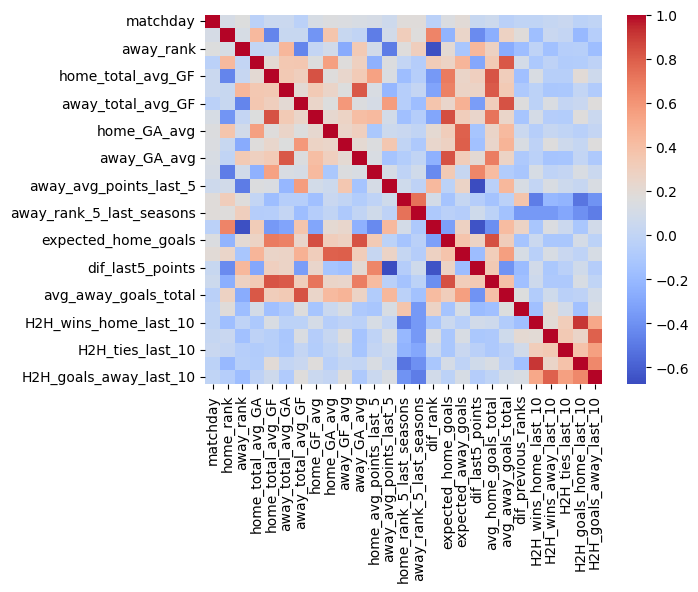

In [26]:
sns.heatmap(X.corr(),cmap='coolwarm')

As there are many variables strongly correlated, we can perform PCA in order to group them and reduce the multicollinearity observed. We decide that reducing to a number of components that give us 85% of the variance explained is good enough, as it might help reducing noise.

In [27]:
pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_.sum()

print(f"Number of components selected: {pca.n_components_}")
print(f"Total variance explained: {explained_variance:.2f}")

Number of components selected: 10
Total variance explained: 0.87


We can see that there is not a component that helps to explain a lot of the variance.

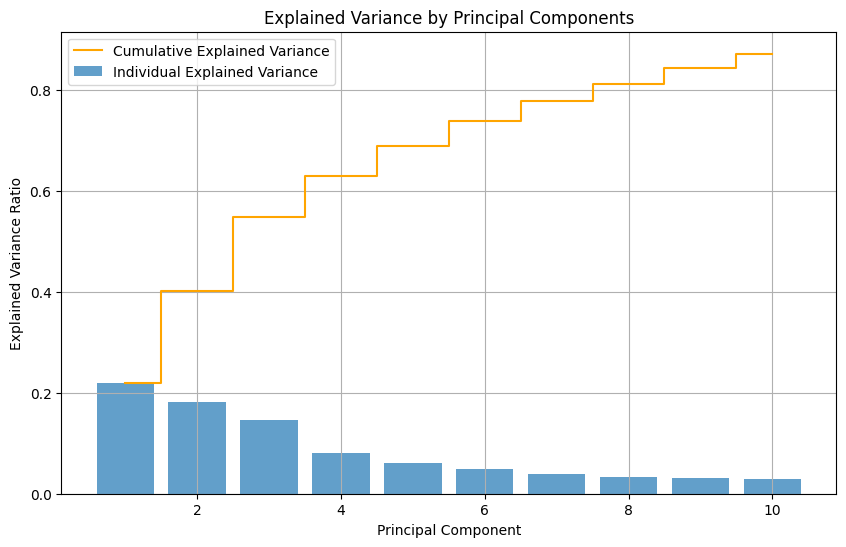

In [28]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot the variance explained by each component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Cumulative Explained Variance', color='orange')

# Labels and title
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid(True)
plt.show()

The results show a 87% variance explanation using 10 principal components. We can leverage the importance of each feature in the PCA by weighting by the explained variance (note that its not the actual percentage that contributes by itself, but it is to compare against the rest of the variables).

In [29]:
feature_names = X.columns

components = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])

weighted_importance = components.abs().mul(explained_variance_ratio, axis=0)

total_weighted_importance = weighted_importance.sum(axis=0)

sorted_total_weighted_importance = total_weighted_importance.sort_values(ascending=False)

print("Sorted Total Feature Importance Across All Components (Weighted by Explained Variance):")
print(sorted_total_weighted_importance)

Sorted Total Feature Importance Across All Components (Weighted by Explained Variance):
home_GA_avg                 0.155698
expected_away_goals         0.153609
away_total_avg_GA           0.152895
home_total_avg_GA           0.151700
away_GF_avg                 0.148944
away_total_avg_GF           0.148633
home_avg_points_last_5      0.147450
avg_away_goals_total        0.145397
home_rank                   0.142571
away_rank_5_last_seasons    0.140240
home_total_avg_GF           0.137429
away_GA_avg                 0.136890
dif_last5_points            0.136663
away_rank                   0.136107
H2H_goals_away_last_10      0.133785
H2H_wins_away_last_10       0.132761
home_rank_5_last_seasons    0.131966
home_GF_avg                 0.131147
H2H_goals_home_last_10      0.125944
away_avg_points_last_5      0.125074
H2H_wins_home_last_10       0.124249
avg_home_goals_total        0.121521
expected_home_goals         0.120374
dif_previous_ranks          0.116840
dif_rank                

# Model training

Before training the algorithms, we first define a `performance` function to compute, for each ML algorithm, the performance metrics. These metrics are then stored in a new data frame called `models_performance`. The metrics that we have chosen are accuracy and weighted F1-Score. The latter asses the imbalance present in the dataset.

## Define training functions

We define a dataframe to store all the information

In [30]:
# Empty df to store the performance of the different models
models_performance = pd.DataFrame(columns=['model', 'data_set', 'cv_avg_accuracy', 'weighted_f1', 'best_parameters'])

In [31]:
def performance(model, y_test, y_pred, plot=True):
    # Classificatin Report shows some metrics to evaluate the model performance
    class_report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = class_report['accuracy']
    weighted_avg_f1 = class_report['weighted avg']['f1-score']
    if not (plot):
        print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    if (plot):
        
        # Plot Confusion Matrix
        labels = ["Home Win", "Away Win", "Tie"]
        sns.heatmap(confusion_matrix(y_test, y_pred),
                    annot=True, fmt="d", cmap="Blues", cbar=False,
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

    return accuracy, weighted_avg_f1

To avoid overfitting when training the models, we employ `k-fold cross-validation`. Moreover, due to the strong class imbalance in the dataset, we addressed it by applying the Synthetic Minority Over-sampling Technique (SMOTE). We also implement a Grid Search of Hyperparameters for each model, so we can find the best combination of parameters. 

In [32]:
def cross_val(model, X, y, param_grid, k=5, plot=True, use_smote=False):
    
    # Step 1: Retrive the name of the df used
    if X is X_pca:
        df_name = "X_pca"
    elif X is X_scaled:
        df_name = "X_scaled"

    # Step 2: Grid_Search
    grid_search = GridSearchCV(model, param_grid, cv=k, scoring='accuracy', n_jobs=-1)    
    
    if use_smote:
        smote = SMOTE(random_state=1)
        X_smote, y_smote = smote.fit_resample(X, y)
        grid_search.fit(X_smote, y_smote)

    else:
        grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    best_estimators = grid_search.best_params_

    # Step 3: K-Fold Cross Validation
    kf = KFold(n_splits=k, shuffle=True, random_state=1)

    fold_accuracies = []
    fold_f1 = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if use_smote:
            smote = SMOTE(random_state=1)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

        accuracy, weighted_avg_f1 = performance(model, y_test, y_pred, plot)
        fold_accuracies.append(accuracy)
        fold_f1.append(weighted_avg_f1)

    # Step 4: Calculate and print average accuracy and weighted F1 score
    cv_avg_accuracy = np.mean(fold_accuracies)
    cv_avg_weighted_f1 = np.mean(fold_f1)
    print(best_estimators)
    print(f"Average Accuracy over {k} folds: {cv_avg_accuracy:.4f}")
    print(f"Average Weighted F1 over {k} folds: {cv_avg_weighted_f1:.4f}")

    return df_name, best_estimators, cv_avg_accuracy, cv_avg_weighted_f1

## Histogram Gradient Boosting

### Example of not balancing

In the following example we can see that if we do not balance our dataset, it basically predicts just for the home team to win. While this gives a higher accuracy (since usually the home team wins), the model is not learning when a match can be a draw or a win for the away team. This results in a lower weighted F1-Score. Therefore, we have decided to solve the imbalance. The accuracy achieved is a bit lower in the end, but the weighted F1-Score is higher and the model is actually something interesting, and not just predicting for the home team to win.

              precision    recall  f1-score   support

           1       0.54      0.99      0.69      5058
           2       0.52      0.06      0.11      2070
           X       0.00      0.00      0.00      2469

    accuracy                           0.53      9597
   macro avg       0.35      0.35      0.27      9597
weighted avg       0.39      0.53      0.39      9597



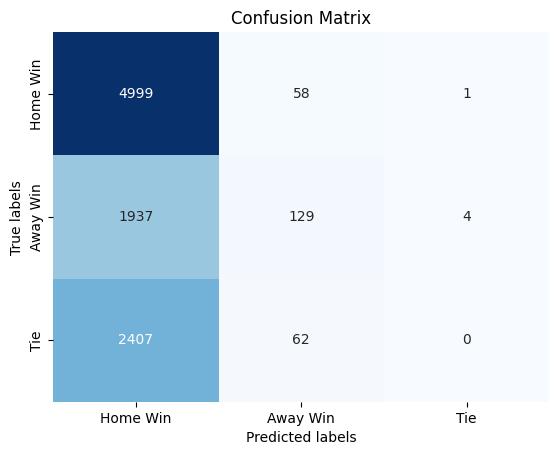

              precision    recall  f1-score   support

           1       0.54      0.99      0.70      5105
           2       0.51      0.07      0.12      2069
           X       0.00      0.00      0.00      2423

    accuracy                           0.54      9597
   macro avg       0.35      0.35      0.27      9597
weighted avg       0.40      0.54      0.40      9597



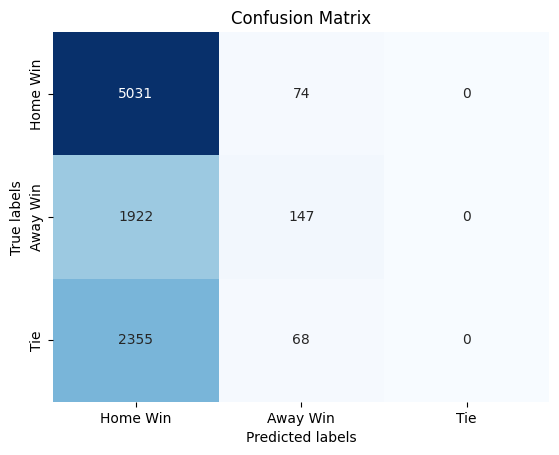

              precision    recall  f1-score   support

           1       0.53      0.98      0.69      5009
           2       0.48      0.07      0.12      2094
           X       0.30      0.00      0.00      2494

    accuracy                           0.53      9597
   macro avg       0.44      0.35      0.27      9597
weighted avg       0.46      0.53      0.39      9597



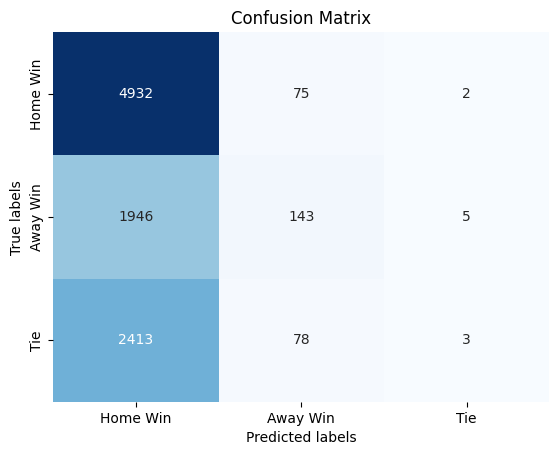

              precision    recall  f1-score   support

           1       0.54      0.99      0.69      5060
           2       0.46      0.06      0.11      2074
           X       0.00      0.00      0.00      2463

    accuracy                           0.53      9597
   macro avg       0.33      0.35      0.27      9597
weighted avg       0.38      0.53      0.39      9597



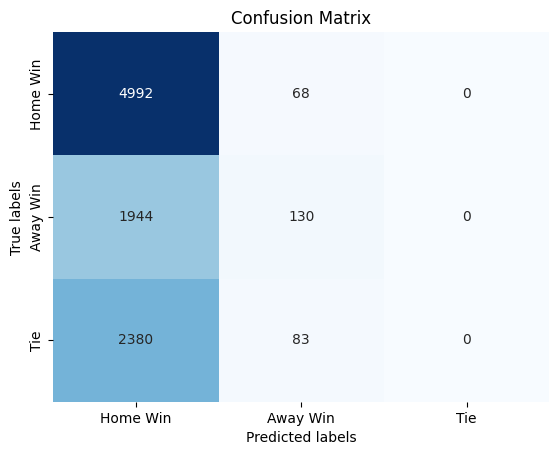

              precision    recall  f1-score   support

           1       0.54      0.98      0.70      5080
           2       0.47      0.08      0.13      2088
           X       0.50      0.00      0.00      2428

    accuracy                           0.54      9596
   macro avg       0.50      0.35      0.28      9596
weighted avg       0.51      0.54      0.40      9596



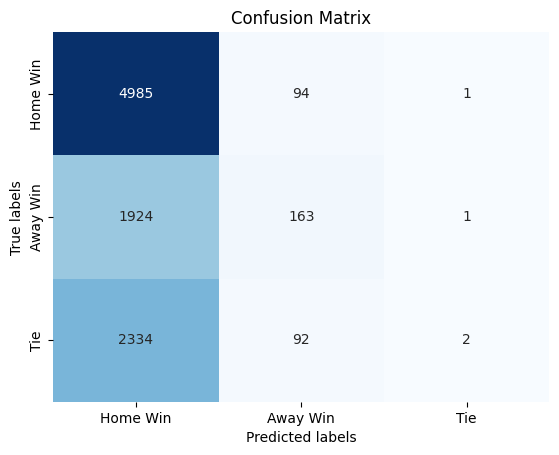

{'learning_rate': 0.01}
Average Accuracy over 5 folds: 0.5347
Average Weighted F1 over 5 folds: 0.3926


In [33]:
param_grid = {
    'learning_rate': [0.01]
}
hgb_model = HistGradientBoostingClassifier()
df_name, hgb_param, hgb_accuracy, hgb_f1_score = cross_val(hgb_model, X_pca, y, param_grid, plot=True, use_smote=False)
models_performance.loc[len(models_performance)] = [type(hgb_model).__name__, df_name, hgb_accuracy,
                                                   hgb_f1_score, hgb_param]

## From now on the data is balanced

As predictors, we use both the data obtained from the PCA, and also from the standardization. We do this to see if it is actually positive to reduce dimensionality, or is it actually better to keep all features.

### Using X_pca data

              precision    recall  f1-score   support

           1       0.63      0.49      0.55      5058
           2       0.29      0.38      0.33      2070
           X       0.29      0.34      0.31      2469

    accuracy                           0.43      9597
   macro avg       0.40      0.40      0.40      9597
weighted avg       0.47      0.43      0.44      9597



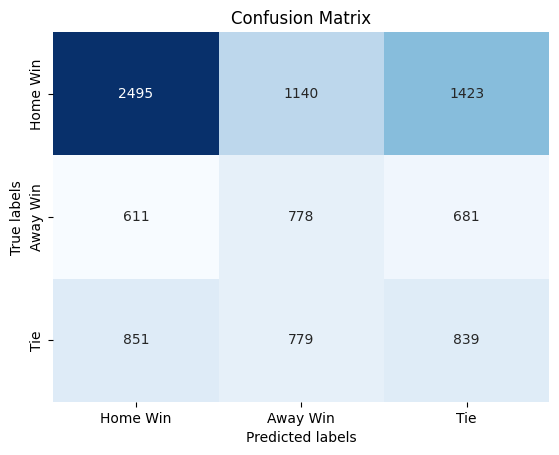

              precision    recall  f1-score   support

           1       0.63      0.48      0.55      5105
           2       0.28      0.39      0.33      2069
           X       0.29      0.34      0.31      2423

    accuracy                           0.43      9597
   macro avg       0.40      0.40      0.40      9597
weighted avg       0.47      0.43      0.44      9597



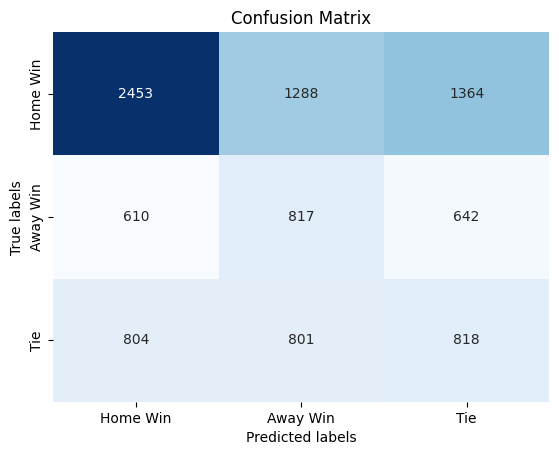

              precision    recall  f1-score   support

           1       0.63      0.49      0.55      5009
           2       0.29      0.40      0.34      2094
           X       0.30      0.34      0.32      2494

    accuracy                           0.43      9597
   macro avg       0.41      0.41      0.40      9597
weighted avg       0.47      0.43      0.44      9597



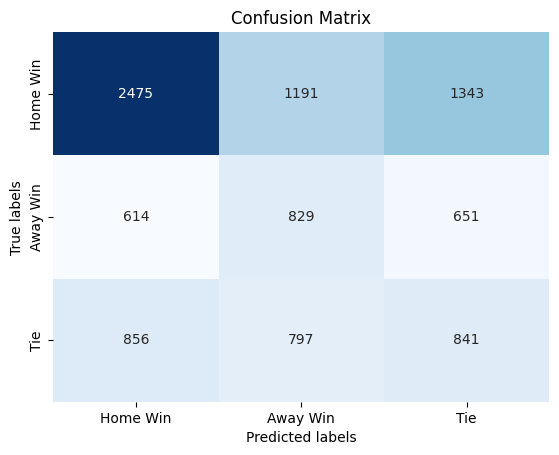

              precision    recall  f1-score   support

           1       0.63      0.49      0.55      5060
           2       0.29      0.38      0.33      2074
           X       0.29      0.35      0.32      2463

    accuracy                           0.43      9597
   macro avg       0.41      0.41      0.40      9597
weighted avg       0.47      0.43      0.44      9597



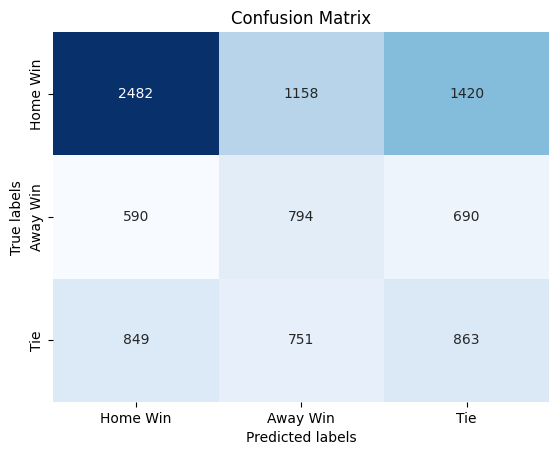

              precision    recall  f1-score   support

           1       0.63      0.49      0.55      5080
           2       0.29      0.39      0.33      2088
           X       0.28      0.33      0.30      2428

    accuracy                           0.43      9596
   macro avg       0.40      0.40      0.39      9596
weighted avg       0.47      0.43      0.44      9596



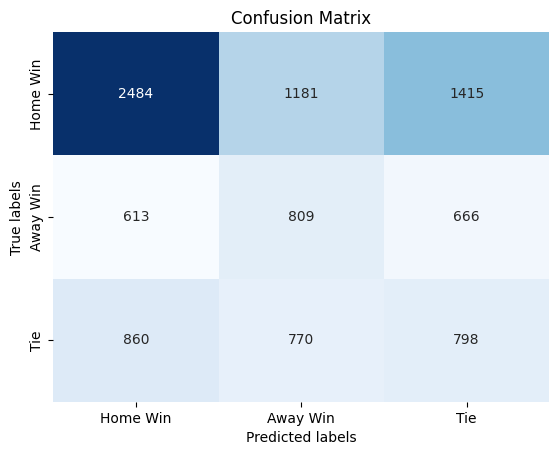

{'l2_regularization': 0.1, 'learning_rate': 0.2, 'max_depth': 20}
Average Accuracy over 5 folds: 0.4288
Average Weighted F1 over 5 folds: 0.4422


In [33]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 10, 20],
    'l2_regularization': [0, 0.1, 0.5]
}
hgb_model = HistGradientBoostingClassifier()
df_name, hgb_param, hgb_accuracy, hgb_f1_score = cross_val(hgb_model, X_pca, y, param_grid, plot=True, use_smote=True)
models_performance.loc[len(models_performance)] = [type(hgb_model).__name__, df_name, hgb_accuracy,
                                                   hgb_f1_score, hgb_param]

### Using X_scaled data

In [34]:
df_name, hgb_param, hgb_accuracy, hgb_f1_score = cross_val(hgb_model, X_scaled, y, param_grid, plot=False, use_smote=True)
models_performance.loc[len(models_performance)] = [type(hgb_model).__name__, df_name, hgb_accuracy,
                                                   hgb_f1_score, hgb_param]

[[4122  413  523]
 [1344  435  291]
 [1815  325  329]]
              precision    recall  f1-score   support

           1       0.57      0.81      0.67      5058
           2       0.37      0.21      0.27      2070
           X       0.29      0.13      0.18      2469

    accuracy                           0.51      9597
   macro avg       0.41      0.39      0.37      9597
weighted avg       0.45      0.51      0.46      9597

[[4142  447  516]
 [1353  429  287]
 [1732  339  352]]
              precision    recall  f1-score   support

           1       0.57      0.81      0.67      5105
           2       0.35      0.21      0.26      2069
           X       0.30      0.15      0.20      2423

    accuracy                           0.51      9597
   macro avg       0.41      0.39      0.38      9597
weighted avg       0.46      0.51      0.46      9597

[[4096  473  440]
 [1315  471  308]
 [1772  376  346]]
              precision    recall  f1-score   support

           1      

## Gradient Boosting

### Using X_pca data

In [35]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}
gb_model = GradientBoostingClassifier()
df_name, gb_param, gb_accuracy, gb_f1_score = cross_val(gb_model, X_pca, y, param_grid, plot = False, use_smote=True)
models_performance.loc[len(models_performance)] = [type(gb_model).__name__, df_name, gb_accuracy, 
                                                   gb_f1_score, gb_param]

[[2198  915 1945]
 [ 463  789  818]
 [ 670  644 1155]]
              precision    recall  f1-score   support

           1       0.66      0.43      0.52      5058
           2       0.34      0.38      0.36      2070
           X       0.29      0.47      0.36      2469

    accuracy                           0.43      9597
   macro avg       0.43      0.43      0.41      9597
weighted avg       0.50      0.43      0.45      9597

[[2345  995 1765]
 [ 549  776  744]
 [ 740  659 1024]]
              precision    recall  f1-score   support

           1       0.65      0.46      0.54      5105
           2       0.32      0.38      0.34      2069
           X       0.29      0.42      0.34      2423

    accuracy                           0.43      9597
   macro avg       0.42      0.42      0.41      9597
weighted avg       0.49      0.43      0.45      9597

[[2285 1082 1642]
 [ 520  827  747]
 [ 740  710 1044]]
              precision    recall  f1-score   support

           1      

### Using X_scaled data

In [36]:
df_name, gb_param, gb_accuracy, gb_f1_score = cross_val(gb_model, X_scaled, y, param_grid, plot = False, use_smote=True)
models_performance.loc[len(models_performance)] = [type(gb_model).__name__, df_name, gb_accuracy, 
                                                   gb_f1_score, gb_param]

[[3958  564  536]
 [1189  587  294]
 [1659  435  375]]
              precision    recall  f1-score   support

           1       0.58      0.78      0.67      5058
           2       0.37      0.28      0.32      2070
           X       0.31      0.15      0.20      2469

    accuracy                           0.51      9597
   macro avg       0.42      0.41      0.40      9597
weighted avg       0.47      0.51      0.47      9597

[[3995  613  497]
 [1188  621  260]
 [1604  473  346]]
              precision    recall  f1-score   support

           1       0.59      0.78      0.67      5105
           2       0.36      0.30      0.33      2069
           X       0.31      0.14      0.20      2423

    accuracy                           0.52      9597
   macro avg       0.42      0.41      0.40      9597
weighted avg       0.47      0.52      0.48      9597

[[4027  603  379]
 [1227  610  257]
 [1699  444  351]]
              precision    recall  f1-score   support

           1      

## Logistic Regression

### Using X_pca data

In [37]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}
LR_model = LogisticRegression()
df_name, LR_param, LR_accuracy, LR_f1_score = cross_val(LR_model, X_pca, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(LR_model).__name__, df_name, LR_accuracy, 
                                                   LR_f1_score, LR_param]

/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag

[[2572 1273 1213]
 [ 543  985  542]
 [ 834  889  746]]
              precision    recall  f1-score   support

           1       0.65      0.51      0.57      5058
           2       0.31      0.48      0.38      2070
           X       0.30      0.30      0.30      2469

    accuracy                           0.45      9597
   macro avg       0.42      0.43      0.42      9597
weighted avg       0.49      0.45      0.46      9597

[[2568 1330 1207]
 [ 596  975  498]
 [ 825  896  702]]
              precision    recall  f1-score   support

           1       0.64      0.50      0.56      5105
           2       0.30      0.47      0.37      2069
           X       0.29      0.29      0.29      2423

    accuracy                           0.44      9597
   macro avg       0.41      0.42      0.41      9597
weighted avg       0.48      0.44      0.45      9597

[[2647 1285 1077]
 [ 609  999  486]
 [ 884  893  717]]
              precision    recall  f1-score   support

           1      

### Using X_scaled data

In [38]:
df_name, LR_param, LR_accuracy, LR_f1_score = cross_val(LR_model, X_scaled, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(LR_model).__name__, df_name, LR_accuracy, 
                                                   LR_f1_score, LR_param]

/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/py_env/quiniela_env/lib/python3.12/site-packages/sklearn/linear_model/_sag

[[2606 1317 1135]
 [ 567 1023  480]
 [ 843  900  726]]
              precision    recall  f1-score   support

           1       0.65      0.52      0.57      5058
           2       0.32      0.49      0.39      2070
           X       0.31      0.29      0.30      2469

    accuracy                           0.45      9597
   macro avg       0.42      0.43      0.42      9597
weighted avg       0.49      0.45      0.46      9597

[[2583 1389 1133]
 [ 596 1006  467]
 [ 828  929  666]]
              precision    recall  f1-score   support

           1       0.64      0.51      0.57      5105
           2       0.30      0.49      0.37      2069
           X       0.29      0.27      0.28      2423

    accuracy                           0.44      9597
   macro avg       0.41      0.42      0.41      9597
weighted avg       0.48      0.44      0.45      9597

[[2672 1329 1008]
 [ 614 1038  442]
 [ 892  910  692]]
              precision    recall  f1-score   support

           1      

## Naive Bayes

### Using X_pca data

In [39]:
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}
NB_model = GaussianNB()
df_name, NB_param, NB_accuracy, NB_f1_score = cross_val(NB_model, X_pca, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(NB_model).__name__, df_name, NB_accuracy, 
                                                   NB_f1_score, NB_param]

[[2099  777 2182]
 [ 466  685  919]
 [ 638  583 1248]]
              precision    recall  f1-score   support

           1       0.66      0.41      0.51      5058
           2       0.33      0.33      0.33      2070
           X       0.29      0.51      0.37      2469

    accuracy                           0.42      9597
   macro avg       0.43      0.42      0.40      9597
weighted avg       0.49      0.42      0.43      9597

[[2148  825 2132]
 [ 484  690  895]
 [ 636  590 1197]]
              precision    recall  f1-score   support

           1       0.66      0.42      0.51      5105
           2       0.33      0.33      0.33      2069
           X       0.28      0.49      0.36      2423

    accuracy                           0.42      9597
   macro avg       0.42      0.42      0.40      9597
weighted avg       0.49      0.42      0.44      9597

[[2080  733 2196]
 [ 492  674  928]
 [ 696  537 1261]]
              precision    recall  f1-score   support

           1      

### Using X_scaled data

In [40]:
df_name, NB_param, NB_accuracy, NB_f1_score = cross_val(NB_model, X_scaled, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(NB_model).__name__, df_name, NB_accuracy, 
                                                   NB_f1_score, NB_param]

[[2055  967 2036]
 [ 412  814  844]
 [ 584  697 1188]]
              precision    recall  f1-score   support

           1       0.67      0.41      0.51      5058
           2       0.33      0.39      0.36      2070
           X       0.29      0.48      0.36      2469

    accuracy                           0.42      9597
   macro avg       0.43      0.43      0.41      9597
weighted avg       0.50      0.42      0.44      9597

[[2067  984 2054]
 [ 437  789  843]
 [ 611  670 1142]]
              precision    recall  f1-score   support

           1       0.66      0.40      0.50      5105
           2       0.32      0.38      0.35      2069
           X       0.28      0.47      0.35      2423

    accuracy                           0.42      9597
   macro avg       0.42      0.42      0.40      9597
weighted avg       0.49      0.42      0.43      9597

[[2085  919 2005]
 [ 469  789  836]
 [ 635  640 1219]]
              precision    recall  f1-score   support

           1      

## Decision Tree

### Using X_pca data

In [41]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5]

}
tree_model = DecisionTreeClassifier()
df_name, tree_param, tree_accuracy, tree_f1_score = cross_val(tree_model, X_pca, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(tree_model).__name__, df_name, tree_accuracy, 
                                                   tree_f1_score, tree_param]

[[1924 1515 1619]
 [ 602  827  641]
 [ 764  877  828]]
              precision    recall  f1-score   support

           1       0.58      0.38      0.46      5058
           2       0.26      0.40      0.31      2070
           X       0.27      0.34      0.30      2469

    accuracy                           0.37      9597
   macro avg       0.37      0.37      0.36      9597
weighted avg       0.43      0.37      0.39      9597

[[1907 1463 1735]
 [ 571  834  664]
 [ 671  864  888]]
              precision    recall  f1-score   support

           1       0.61      0.37      0.46      5105
           2       0.26      0.40      0.32      2069
           X       0.27      0.37      0.31      2423

    accuracy                           0.38      9597
   macro avg       0.38      0.38      0.36      9597
weighted avg       0.45      0.38      0.39      9597

[[2027 1313 1669]
 [ 575  778  741]
 [ 789  825  880]]
              precision    recall  f1-score   support

           1      

### Using X_scaled data

In [42]:
df_name, tree_param, tree_accuracy, tree_f1_score = cross_val(tree_model, X_scaled, y, param_grid, plot = False,use_smote=True)
models_performance.loc[len(models_performance)] = [type(tree_model).__name__, df_name, tree_accuracy, 
                                                   tree_f1_score, tree_param]

[[2899 1127 1032]
 [ 899  751  420]
 [1214  723  532]]
              precision    recall  f1-score   support

           1       0.58      0.57      0.58      5058
           2       0.29      0.36      0.32      2070
           X       0.27      0.22      0.24      2469

    accuracy                           0.44      9597
   macro avg       0.38      0.38      0.38      9597
weighted avg       0.44      0.44      0.43      9597

[[2344 1117 1644]
 [ 718  611  740]
 [ 902  611  910]]
              precision    recall  f1-score   support

           1       0.59      0.46      0.52      5105
           2       0.26      0.30      0.28      2069
           X       0.28      0.38      0.32      2423

    accuracy                           0.40      9597
   macro avg       0.38      0.38      0.37      9597
weighted avg       0.44      0.40      0.42      9597

[[2441 1128 1440]
 [ 721  657  716]
 [1000  657  837]]
              precision    recall  f1-score   support

           1      

## Random Forest

### Using X_pca data

              precision    recall  f1-score   support

           1       0.64      0.48      0.55      5058
           2       0.33      0.40      0.36      2070
           X       0.29      0.39      0.33      2469

    accuracy                           0.44      9597
   macro avg       0.42      0.42      0.42      9597
weighted avg       0.49      0.44      0.45      9597



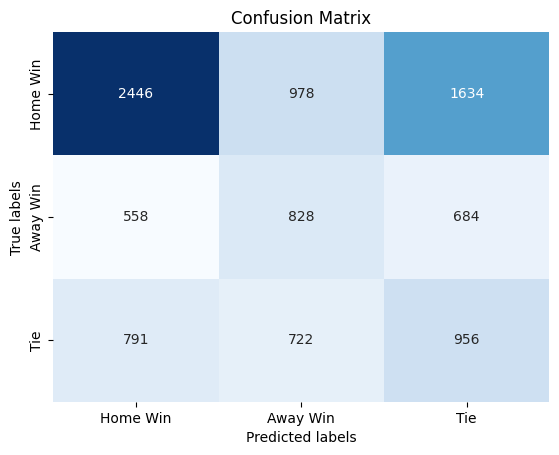

              precision    recall  f1-score   support

           1       0.65      0.48      0.55      5105
           2       0.32      0.43      0.37      2069
           X       0.29      0.36      0.32      2423

    accuracy                           0.44      9597
   macro avg       0.42      0.42      0.41      9597
weighted avg       0.49      0.44      0.45      9597



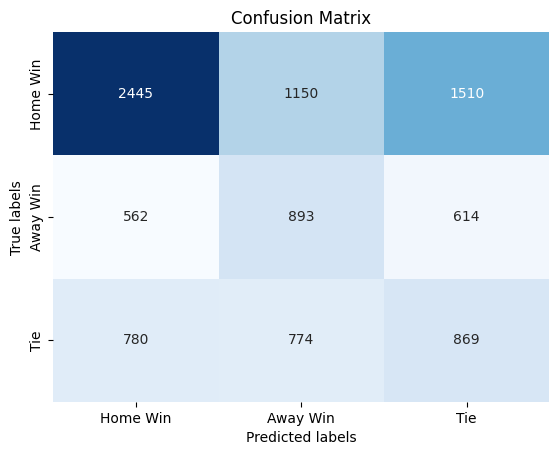

              precision    recall  f1-score   support

           1       0.64      0.49      0.55      5009
           2       0.32      0.42      0.37      2094
           X       0.30      0.37      0.33      2494

    accuracy                           0.44      9597
   macro avg       0.42      0.43      0.42      9597
weighted avg       0.48      0.44      0.45      9597



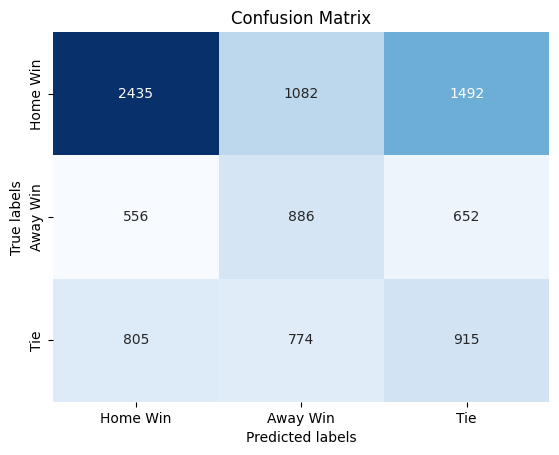

              precision    recall  f1-score   support

           1       0.66      0.50      0.57      5060
           2       0.31      0.38      0.34      2074
           X       0.30      0.39      0.34      2463

    accuracy                           0.45      9597
   macro avg       0.42      0.42      0.42      9597
weighted avg       0.49      0.45      0.46      9597



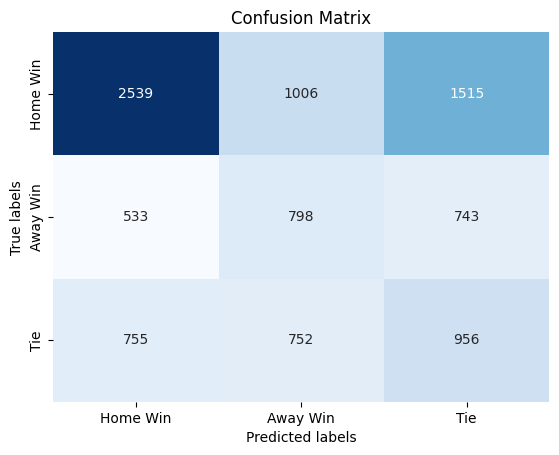

              precision    recall  f1-score   support

           1       0.65      0.50      0.57      5080
           2       0.32      0.38      0.35      2088
           X       0.28      0.36      0.32      2428

    accuracy                           0.44      9596
   macro avg       0.41      0.42      0.41      9596
weighted avg       0.48      0.44      0.45      9596



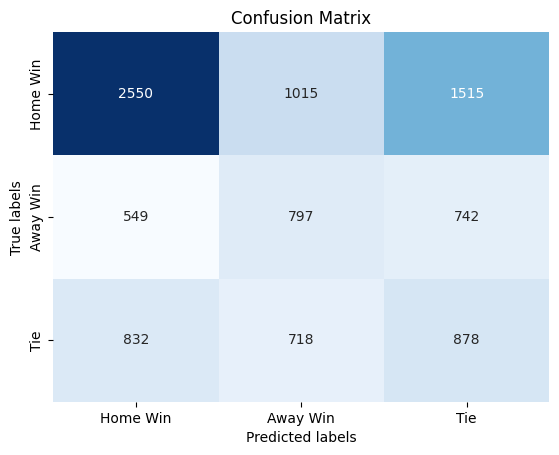

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Average Accuracy over 5 folds: 0.4416
Average Weighted F1 over 5 folds: 0.4556


In [43]:
param_grid = {
    'n_estimators': [50, 300],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 5]
}
RF_model = RandomForestClassifier()
df_name, RF_param, RF_accuracy, RF_f1_score = cross_val(RF_model, X_pca, y, param_grid, plot = True,use_smote=True)
models_performance.loc[len(models_performance)] = [type(RF_model).__name__, df_name, RF_accuracy, 
                                                   RF_f1_score, RF_param]

### Using X_scaled data

              precision    recall  f1-score   support

           1       0.63      0.58      0.60      5058
           2       0.34      0.40      0.37      2070
           X       0.31      0.32      0.31      2469

    accuracy                           0.47      9597
   macro avg       0.43      0.43      0.43      9597
weighted avg       0.49      0.47      0.48      9597



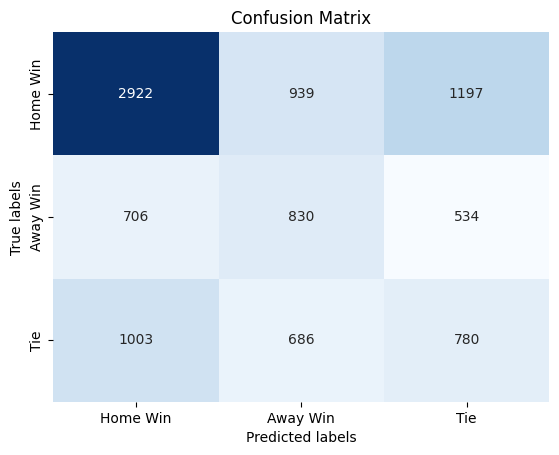

              precision    recall  f1-score   support

           1       0.63      0.56      0.59      5105
           2       0.32      0.40      0.35      2069
           X       0.29      0.30      0.29      2423

    accuracy                           0.46      9597
   macro avg       0.41      0.42      0.41      9597
weighted avg       0.48      0.46      0.47      9597



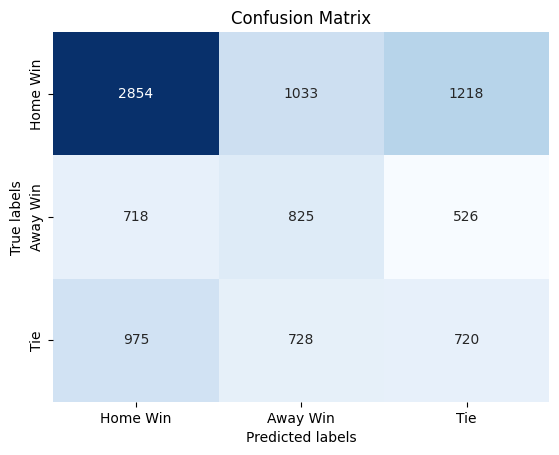

              precision    recall  f1-score   support

           1       0.62      0.58      0.60      5009
           2       0.34      0.40      0.37      2094
           X       0.31      0.30      0.30      2494

    accuracy                           0.47      9597
   macro avg       0.42      0.43      0.42      9597
weighted avg       0.48      0.47      0.47      9597



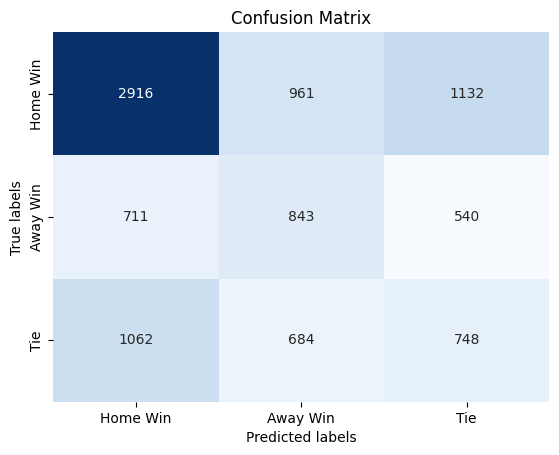

              precision    recall  f1-score   support

           1       0.65      0.59      0.61      5060
           2       0.32      0.36      0.34      2074
           X       0.32      0.34      0.33      2463

    accuracy                           0.47      9597
   macro avg       0.43      0.43      0.43      9597
weighted avg       0.49      0.47      0.48      9597



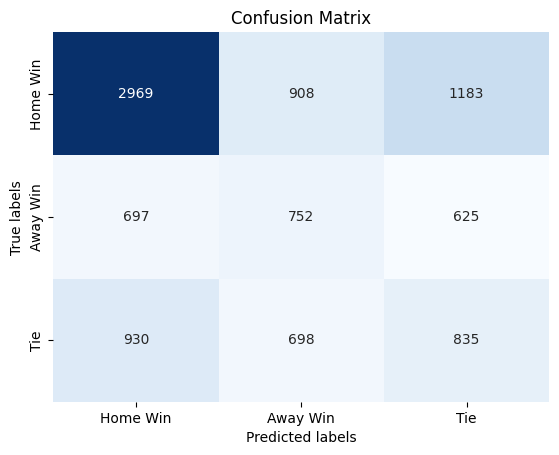

              precision    recall  f1-score   support

           1       0.63      0.57      0.60      5080
           2       0.33      0.36      0.35      2088
           X       0.27      0.31      0.29      2428

    accuracy                           0.46      9596
   macro avg       0.41      0.41      0.41      9596
weighted avg       0.47      0.46      0.46      9596



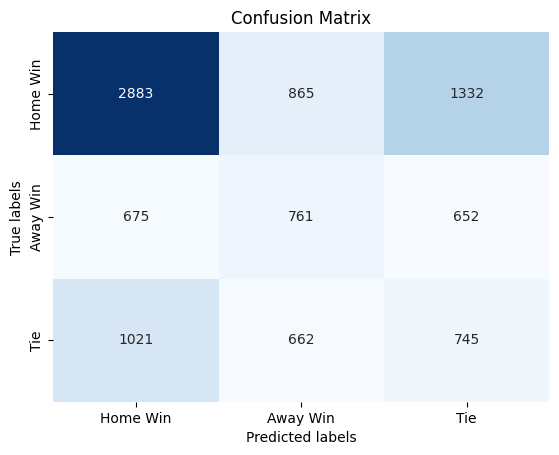

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Average Accuracy over 5 folds: 0.4665
Average Weighted F1 over 5 folds: 0.4725


In [44]:
df_name, RF_param, RF_accuracy, RF_f1_score = cross_val(RF_model, X_scaled, y, param_grid, plot = True,use_smote=True)
models_performance.loc[len(models_performance)] = [type(RF_model).__name__, df_name, RF_accuracy, 
                                                   RF_f1_score, RF_param]

In the displayed confusion matrices we can see how it is predicting for all classes, and in some models the best results are the diagonal (which is what we want in a confusion matrix). We can also observe that for home wins, usually the error is that the model predicts a draw, which makes more sense than if the model predicted an away win. Similar happens for the Ties, the predicition error is usually that it was predicted as a home win, which also makes sense.

## Best model?

We display the dataframe containing all the information, so we can see which are the best models, which type of data is better to use. We obtain that the best model is the GradientBosstingClassifier using the scaled for both the accuracy and the weighted F1-Score. Therefore, we can conclude that it is the best model for the problem that we are trying to solve, the prediction of the Quiniela.

In [45]:
models_performance = models_performance.sort_values(['cv_avg_accuracy'], ascending=False)
models_performance

,model,data_set,cv_avg_accuracy,weighted_f1,best_parameters
3,GradientBoostingClassifier,X_scaled,0.513984,0.472895,"{'learning_rate': 0.1, 'n_estimators': 100}"
1,HistGradientBoostingClassifier,X_scaled,0.511212,0.458961,"{'l2_regularization': 0, 'learning_rate': 0.2,..."
11,RandomForestClassifier,X_scaled,0.466468,0.472516,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
5,LogisticRegression,X_scaled,0.450108,0.459352,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin..."
4,LogisticRegression,X_pca,0.448003,0.458666,"{'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}"
10,RandomForestClassifier,X_pca,0.441626,0.455597,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,X_pca,0.431623,0.446222,"{'learning_rate': 0.01, 'n_estimators': 50}"
0,HistGradientBoostingClassifier,X_pca,0.428789,0.442202,"{'l2_regularization': 0.1, 'learning_rate': 0...."
6,GaussianNB,X_pca,0.420390,0.434157,{'var_smoothing': 1e-09}
7,GaussianNB,X_scaled,0.419952,0.434715,{'var_smoothing': 1e-09}


### ROC-AUC Curve of the best model

To analyse the performance of our best model, we have decided to plot the ROC-AUC Curve, as it can help us understand how it performs for each class. In the graphic we can see that the curve is above the random curve for all classes, which is good, becaue it means that our model is better than predicting at random for all classes. This would not have happened if we had not balanced the dataset. Nonetheless, the lower macro-average than micro-average indicates that our model is still better at predicting some classes than others.

The result is not impresive, but is the best we could obtain and it is quite decent :)

Micro-averaged One-vs-Rest ROC AUC score:
0.71
Macro-averaged One-vs-Rest ROC AUC score:
0.63


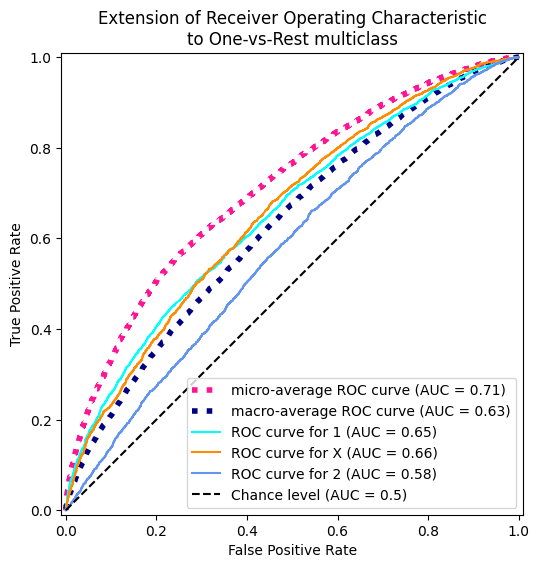

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)  # Set max_iter higher if convergence issues occur
y_score  = clf.fit(X_train, y_train).predict_proba(X_test)


label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fpr, tpr, roc_auc = dict(), dict(), dict()

fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(3):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 3

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

fig, ax = plt.subplots(figsize=(6, 6))
target_names = ['1','X','2']
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)